In [354]:
import pandas as pd
import requests, json
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### 自動生成 24 個月份的列表，從 2021 年 1 月開始

In [355]:
def generate_date_list(start_date, months):
    date_list = []
    start = datetime.strptime(start_date, "%Y%m%d")
    for i in range(months):
        year_month = start + timedelta(days=30 * i)  # 每次增加一個月
        date_str = year_month.strftime("%Y%m01")  # 每個月的第一天
        date_list.append(date_str)
    return date_list

### 下載證交所資料

In [356]:
def fetch_data(date, stock_no):
    url = f'https://www.twse.com.tw/exchangeReport/STOCK_DAY?response=json&date={date}&stockNo={stock_no}'
    html = requests.get(url)
    content = json.loads(html.text)
    stock_data = content['data']
    col_name = content['fields']
    df = pd.DataFrame(data=stock_data, columns=col_name)
    return df

### 將民國年轉換為西元年

In [357]:
def convert_minguo_to_ad(date_str):
    # 假設日期格式為 "109/01/01"
    year, month, day = date_str.split('/')
    year = str(int(year) + 1911)
    return f'{year}-{month}-{day}'

### 爬取證交所 2330.tw 股價

In [358]:
# 生成 24 個月份的日期列表，代表兩年
date_list = generate_date_list('20220101', 24)
stock_no = '2330'
df_list = []

for date in date_list:
    df = fetch_data(date, stock_no)
    df_list.append(df)

# 將多個月份的資料合併
df_twse = pd.concat(df_list)

# 將日期轉換為西元年
df_twse['日期'] = df_twse['日期'].apply(convert_minguo_to_ad)
# 轉換為 datetime 格式並設置為索引
df_twse['日期'] = pd.to_datetime(df_twse['日期'], format='%Y-%m-%d')
df_twse.set_index('日期', inplace=True)

df_twse.tail()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數
日期,,,,,,,,
2023-11-24,"12,503,334","7,192,811,445",577.00,578.00,574.00,575.00,-3.00,"12,961"
2023-11-27,"20,321,872","11,598,721,713",573.00,577.00,568.00,568.00,-7.00,"28,620"
2023-11-28,"26,932,029","15,393,289,150",565.00,576.00,565.00,575.00,+7.00,"17,693"
2023-11-29,"27,786,565","15,937,354,487",578.00,579.00,570.00,574.00,-1.00,"23,135"
2023-11-30,"54,365,027","31,284,297,816",576.00,577.00,570.00,577.00,+3.00,"18,807"


### 修正表格部分欄位資料型態並轉換為數字型態

In [359]:
df_twse['開盤價'] = pd.to_numeric(df_twse['開盤價'].str.replace(',', ''), errors='coerce')
df_twse['收盤價'] = pd.to_numeric(df_twse['收盤價'].str.replace(',', ''), errors='coerce')
df_twse['最高價'] = pd.to_numeric(df_twse['最高價'].str.replace(',', ''), errors='coerce')
df_twse['最低價'] = pd.to_numeric(df_twse['最低價'].str.replace(',', ''), errors='coerce')

### 1. 計算技術指標（SMA、RSI、MACD）

In [360]:
# RSI 計算
def calculate_rsi(series, period=14):
    delta = series.diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

In [361]:
# 計算SMA (簡單移動平均)
df_twse['SMA_20'] = df_twse['收盤價'].rolling(window=20).mean()

# 計算 RSI
df_twse['RSI_14'] = calculate_rsi(df_twse['收盤價'])

# 計算MACD
short_window = 12
long_window = 26
signal_window = 9
df_twse['EMA12'] = df_twse['收盤價'].ewm(span=short_window, adjust=False).mean()
df_twse['EMA26'] = df_twse['收盤價'].ewm(span=long_window, adjust=False).mean()
df_twse['MACD'] = df_twse['EMA12'] - df_twse['EMA26']
df_twse['MACD_Signal'] = df_twse['MACD'].ewm(span=signal_window, adjust=False).mean()
df_twse.tail()

,成交股數,成交金額,開盤價,最高價,最低價,收盤價,漲跌價差,成交筆數,SMA_20,RSI_14,EMA12,EMA26,MACD,MACD_Signal
日期,,,,,,,,,,,,,,
2023-11-24,"12,503,334","7,192,811,445",577.0,578.0,574.0,575.0,-3.00,"12,961",561.95,71.186441,572.538736,562.541337,9.997398,9.134503
2023-11-27,"20,321,872","11,598,721,713",573.0,577.0,568.0,568.0,-7.00,"28,620",563.75,60.655738,571.840469,562.945683,8.894786,9.086560
2023-11-28,"26,932,029","15,393,289,150",565.0,576.0,565.0,575.0,+7.00,"17,693",566.05,64.179104,572.326550,563.838595,8.487955,8.966839
2023-11-29,"27,786,565","15,937,354,487",578.0,579.0,570.0,574.0,-1.00,"23,135",568.35,62.686567,572.584004,564.591292,7.992712,8.772014
2023-11-30,"54,365,027","31,284,297,816",576.0,577.0,570.0,577.0,+3.00,"18,807",569.85,64.285714,573.263388,565.510455,7.752933,8.568197


In [362]:
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_twse['Volume'] = pd.to_numeric(df_twse['Volume'].str.replace(',', ''), errors='coerce')

### 2.可視化 K 線圖

C:\Users\謝孟達\AppData\Local\Temp\ipykernel_12612\1004898643.py:15: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  df_recent_six_months = df_twse.last("6ME")


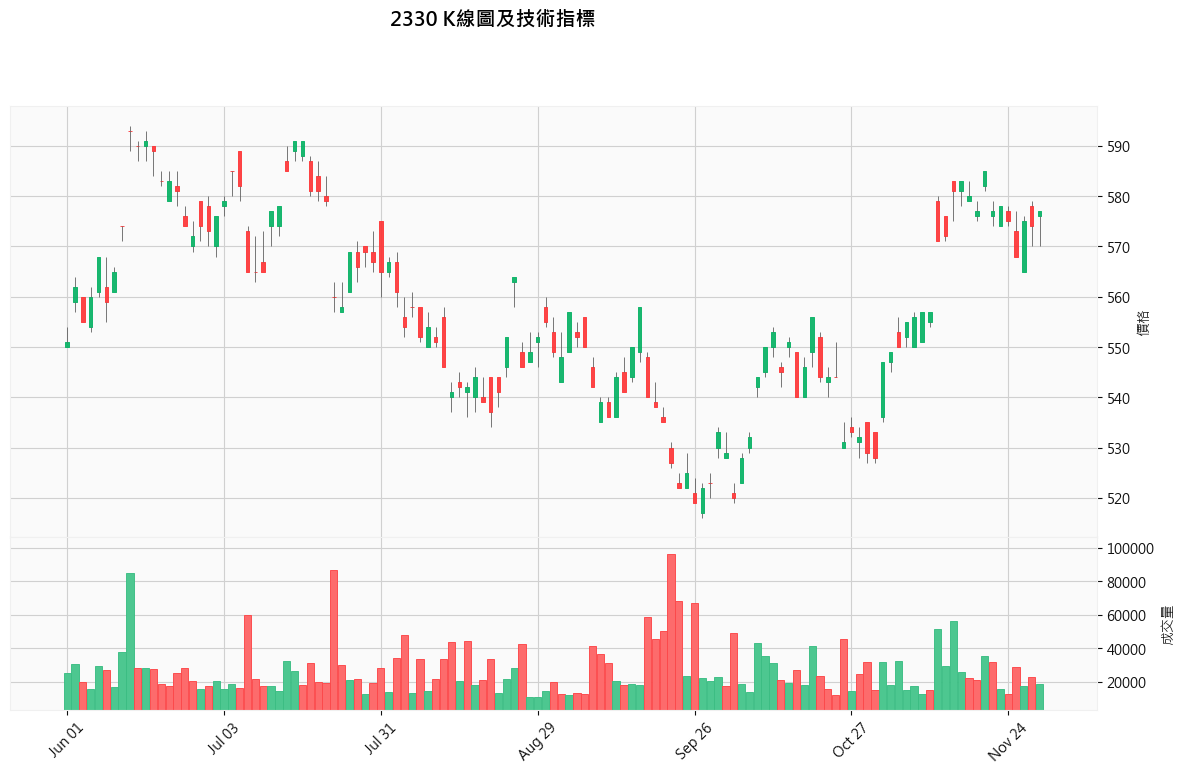

In [363]:
import mplfinance as mpf

# 設定字體為 Microsoft JhengHei
s = mpf.make_mpf_style(base_mpf_style='yahoo', rc={'font.family': 'Microsoft JhengHei', 'axes.unicode_minus': 'False'})
# 將欄位名稱改為英文
df_twse.rename(columns={'開盤價': 'Open', '最高價': 'High', '最低價': 'Low', '收盤價': 'Close', '成交筆數': 'Volume'}, inplace=True)
# 移除有 NaN 值的列
df_twse.dropna(subset=['Open', 'High', 'Low', 'Close', 'Volume'], inplace=True)
df_twse['Volume'] = df_twse['Volume'].astype(float)

# 準備 K 線圖所需的資料
df_candle = df_twse[['Open', 'High', 'Low', 'Close', 'Volume']]

# 選取最後六個月的資料
df_recent_six_months = df_twse.last("6ME")

# 繪製 K 線圖，並疊加 SMA
Kbar_plt, axes = mpf.plot(df_recent_six_months, type='candle', style=s, volume=True, 
         title=f'{stock_no} K線圖及技術指標', ylabel='價格', ylabel_lower='成交量', figratio=(14, 8), figscale=1.5, returnfig=True)

Kbar_plt.savefig('Kbar.png')

### 3.技術指標結合機器學習（線性回歸、決策樹、隨機森林）預測股價漲跌。使用技術指標作為特徵來預測第 n 天的股價

In [364]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [365]:
# 移除 NaN 值
df_twse.dropna(subset=['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal'], inplace=True)

# 建立漲跌標籤，1 表示漲，0 表示跌
df_twse['Price_Up'] = np.where(df_twse['Close'].shift(-1) > df_twse['Close'], 1, 0)

# 準備特徵和標籤
X = df_twse[['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal']]
y = df_twse['Price_Up']


# 分割資料為訓練集和測試集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 機器學習模型：線性回歸、決策樹、隨機森林
# 1. 線性回歸
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
y_pred_lr = np.where(y_pred_lr >= 0.5, 1, 0)  # 將預測結果轉換為二元分類

# 2. 決策樹
tree = DecisionTreeClassifier()
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)

# 3. 隨機森林
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)
y_pred_forest = forest.predict(X_test)

# 評估模型準確率
print(f"線性回歸準確率: {accuracy_score(y_test, y_pred_lr)}")
print(f"決策樹準確率: {accuracy_score(y_test, y_pred_tree)}")
print(f"隨機森林準確率: {accuracy_score(y_test, y_pred_forest)}")

線性回歸準確率: 0.5
決策樹準確率: 0.5106382978723404
隨機森林準確率: 0.44680851063829785


線性回歸模型的回測盈餘: 39.0
決策樹模型的回測盈餘: 11.0
隨機森林模型的回測盈餘: 40.0


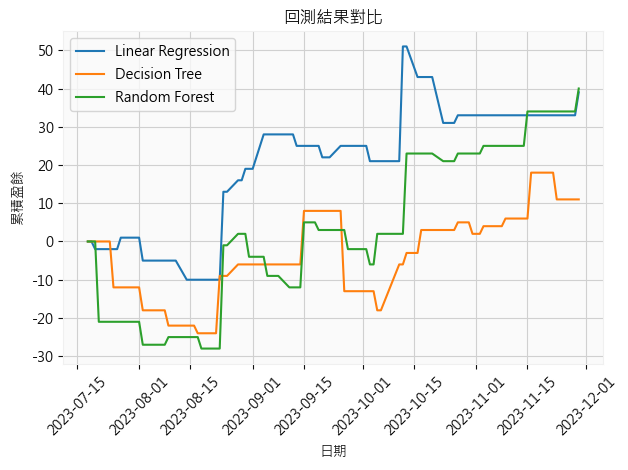

In [366]:
# 回測分析：交易策略，假設每次買入/賣出 1 單位
def backtest_strategy(predictions, prices, dates):
    balance = 0
    position = 0  # 持倉狀態，1 表示持有，0 表示空倉
    balance_history = []
    backtest_dates = []  # 同步日期
    for i in range(len(predictions) - 1):
        if predictions[i] == 1 and position == 0:  # 預測上漲且空倉，買入
            position = prices[i]
        elif predictions[i] == 0 and position > 0:  # 預測下跌且有倉位，賣出
            balance += prices[i] - position
            position = 0
        balance_history.append(balance)  # 記錄每次交易後的餘額
        backtest_dates.append(dates[i])  # 記錄對應的日期
    if position > 0:  # 如果最後一天還有持倉，將持倉賣出
        balance += prices[-1] - position
        balance_history.append(balance)
        backtest_dates.append(dates[-1])  # 最後一次交易的日期
    return balance, balance_history, backtest_dates

# 回測三種模型的表現
price_history = df_twse['Close'].iloc[-len(y_test):].values  # 測試集對應的歷史價格
dates = df_twse.index[-len(y_test):]  # 獲取測試集對應的日期

lr_balance, lr_history, lr_dates = backtest_strategy(y_pred_lr, price_history, dates)
tree_balance, tree_history, tree_dates = backtest_strategy(y_pred_tree, price_history, dates)
forest_balance, forest_history, forest_dates = backtest_strategy(y_pred_forest, price_history, dates)

# 輸出回測結果
print(f"線性回歸模型的回測盈餘: {lr_balance}")
print(f"決策樹模型的回測盈餘: {tree_balance}")
print(f"隨機森林模型的回測盈餘: {forest_balance}")

# 繪製每種模型的歷史回測盈餘對比圖，保證日期和盈餘數量一致
plt.plot(lr_dates, lr_history, label='Linear Regression')
plt.plot(tree_dates, tree_history, label='Decision Tree')
plt.plot(forest_dates, forest_history, label='Random Forest')
plt.title('回測結果對比')
plt.xlabel('日期')
plt.ylabel('累積盈餘')
plt.xticks(rotation=45)  # 日期軸標籤旋轉
plt.legend()
plt.tight_layout()  # 自動調整佈局
# 保存圖表到 PNG 文件
plt.savefig('backtest.png')
plt.show()

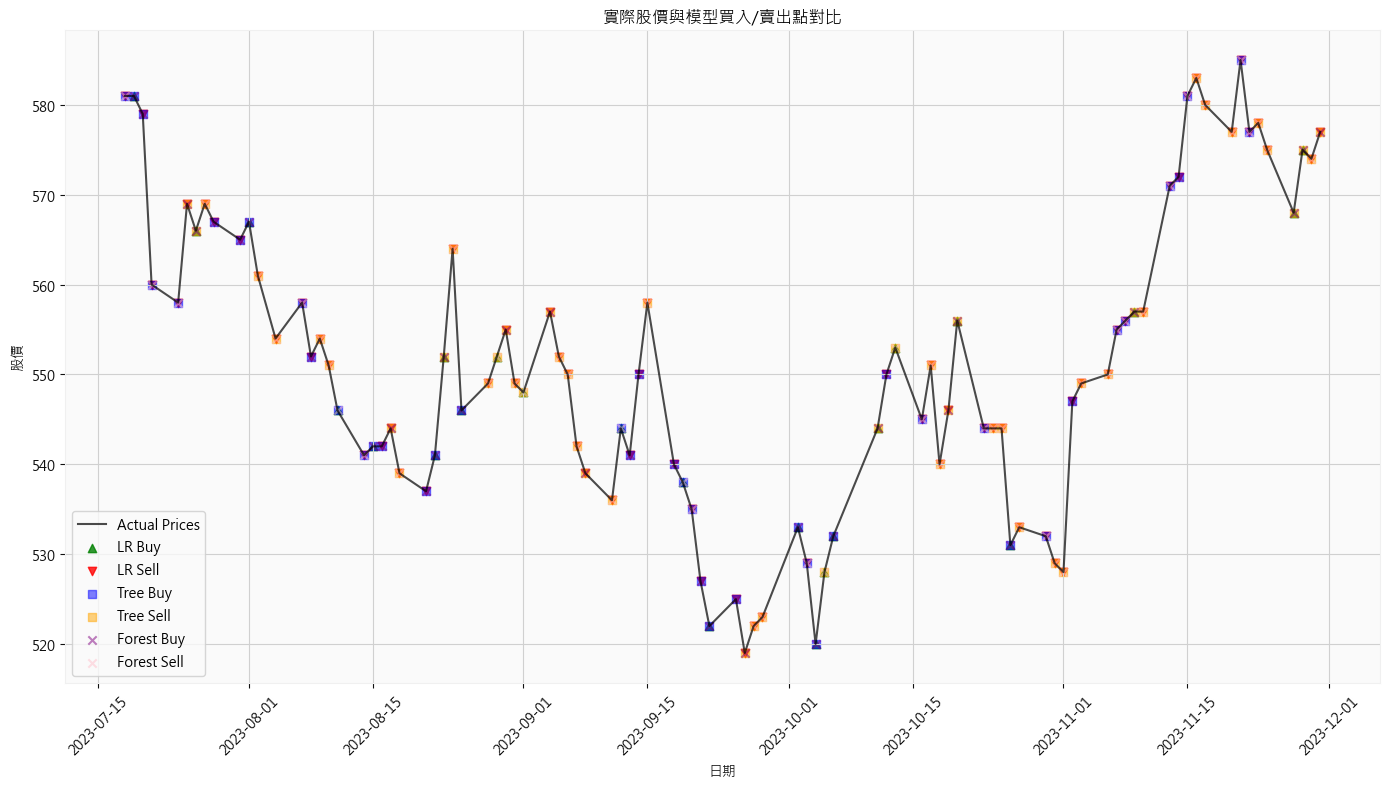

In [367]:
# 繪製圖表，顯示實際股價和三種模型的買入/賣出點
plt.figure(figsize=(14, 8))

# 實際股價走勢
plt.plot(dates, price_history, label='Actual Prices', color='black', alpha=0.7)

# 標記線性回歸模型的買入/賣出點
plt.scatter(dates[y_pred_lr == 1], price_history[y_pred_lr == 1], color='green', label='LR Buy', marker='^', alpha=0.8)  # 買入點
plt.scatter(dates[y_pred_lr == 0], price_history[y_pred_lr == 0], color='red', label='LR Sell', marker='v', alpha=0.8)   # 賣出點

# 標記決策樹模型的買入/賣出點，使用正方形
plt.scatter(dates[y_pred_tree == 1], price_history[y_pred_tree == 1], color='blue', label='Tree Buy', marker='s', alpha=0.5)  # 買入點
plt.scatter(dates[y_pred_tree == 0], price_history[y_pred_tree == 0], color='orange', label='Tree Sell', marker='s', alpha=0.5)  # 賣出點

# 標記隨機森林模型的買入/賣出點，使用 X
plt.scatter(dates[y_pred_forest == 1], price_history[y_pred_forest == 1], color='purple', label='Forest Buy', marker='x', alpha=0.5)  # 買入點
plt.scatter(dates[y_pred_forest == 0], price_history[y_pred_forest == 0], color='pink', label='Forest Sell', marker='x', alpha=0.5)   # 賣出點

# 添加圖例和標題
plt.title('實際股價與模型買入/賣出點對比')
plt.xlabel('日期')
plt.ylabel('股價')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()

# 保存圖表到 PNG 文件
plt.savefig('model_predictions_vs_actual_prices.png')
# 顯示圖表
plt.show()